## Dorian 2019

"Dorian made landfall over Barbados as a very compact cyclone around 0130 UTC 27
August with 45-kt winds. It then moved across the remainder of the Windward Islands, with its
center passing directly over St. Lucia around 1100 UTC that day. The high mountains of that
island disrupted the organization of the cyclone’s low-level circulation, and the center then reformed to the north."

This makes Rmax increasing a little bit even during intensification.

Intensifying phase: Dorian 2019, Lester 2016, Sam 2021 (no MAXSS on this one)

Stationary phase: Hector 2018

Weakening phase: Marie 2020

In [67]:
# General
# import glob
import os.path
# import warnings
# warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
import copy

# Arrays & Displays
import xarray as xr
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import pandas as pd

# Data treatment
from datetime import datetime

# Custom
import functions as f
import dataUtils as du

# Statistics
from sklearn import linear_model, neighbors
from pykalman import KalmanFilter

# Default parameters
mpl.rcParams.update({'font.size': 18})
mpl.rcParams['figure.figsize'] = (15, 10)
mpl.rcParams['axes.facecolor'] = 'white'
mpl.rcParams['figure.facecolor'] = 'white'

In [2]:
PATHS = {
    'ds_glob_path':    '/home/arthur/data/cyclobs/SAR_compilations_in_nc/SAR_centered_rotated_files_13052022_with_extra_params.nc',
    'sar_dir':         '/home/arthur/data/cyclobs/centered_rotated_files_31012022/',
}

In [4]:
### OPEN DATA
dsg = xr.open_dataset(PATHS['ds_glob_path'])

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/backends/plugins.py:71: RuntimeWarning: Engine 'cfgrib' loading failed:
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/lib-dynload/../../libffi.so.8: version `LIBFFI_CLOSURE_7.0' not found (required by /home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/_cffi_backend.cpython-38-x86_64-linux-gnu.so)
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


In [12]:
dsg.where(dsg.storm_name == 'DORIAN', drop=True).sat_file

<xarray.DataArray 'sat_file' (time: 3)>
array([array('s1a-iw-owi-cm-20190906t224121-20190906t224301-000003-0346EC_sw.nc',
             dtype=object)                                                       ,
       array('s1a-iw-owi-cm-20190830t224548-20190830t224705-000003-03435D_sw.nc',
             dtype=object)                                                       ,
       array('s1b-iw-owi-cm-20190829t102127-20190829t102221-000003-0217F3_sw.nc',
             dtype=object)                                                       ],
      dtype=object)
Coordinates:
  * time     (time) datetime64[ns] 2019-09-06T22:42:11 ... 2019-08-29T10:21:54

In [14]:
### DORIAN
p1 = 's1b-iw-owi-ca-20190829t102127-20190829t102221-000003-0217F3_sw_al052019_cyclone.nc'
p2 = 's1a-iw-owi-ca-20190830t224548-20190830t224705-000003-03435D_sw_al052019_cyclone.nc'
p3 = 's1a-iw-owi-ca-20190906t224121-20190906t224301-000003-0346EC_sw_al052019_cyclone.nc'

Text(0.5, 1.0, 'DORIAN, AL052019')

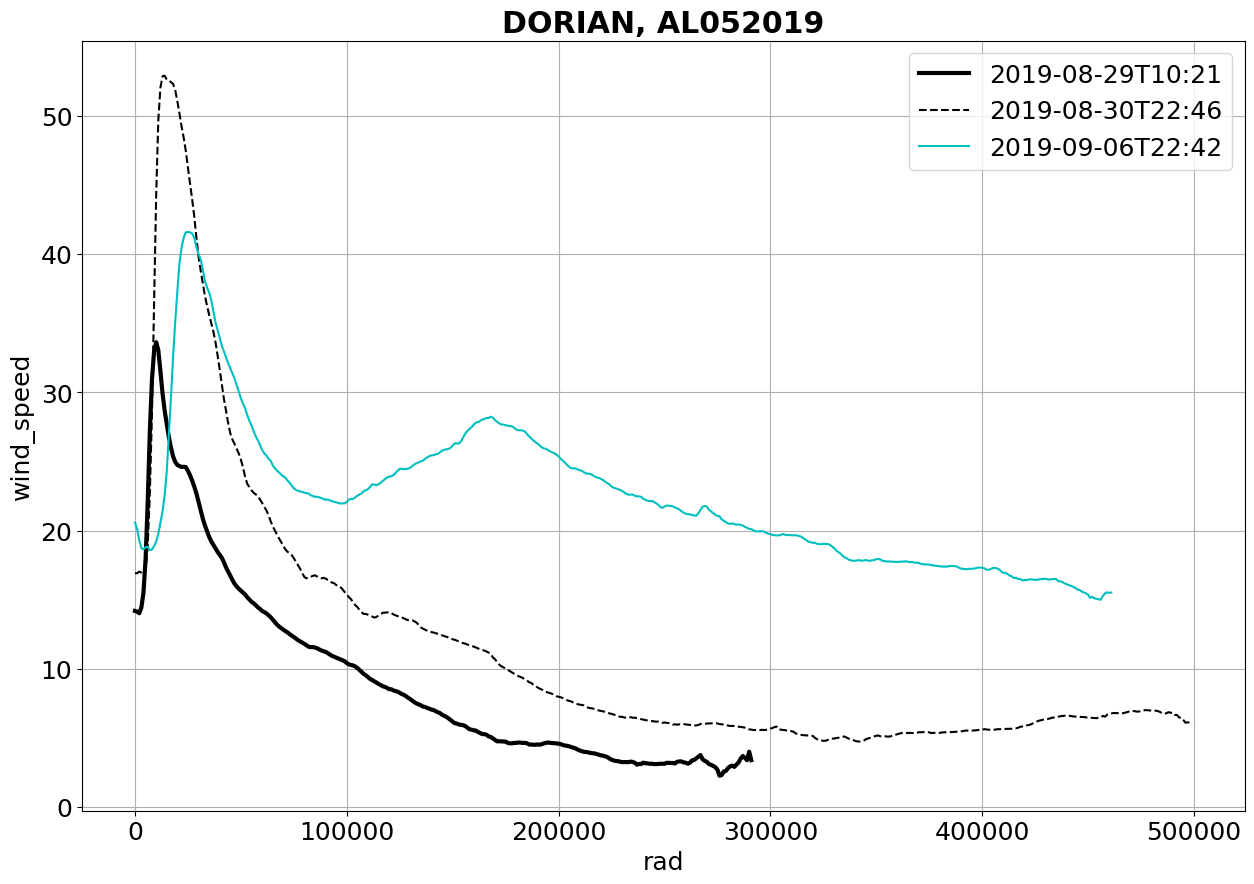

In [15]:
ds1 = xr.open_dataset(PATHS['sar_dir'] + p1).isel(time=0)
ds2 = xr.open_dataset(PATHS['sar_dir'] + p2).isel(time=0)
ds3 = xr.open_dataset(PATHS['sar_dir'] + p3).isel(time=0)

ws1 = ds1.wind_speed.mean(dim='theta', skipna=True)
ws2 = ds2.wind_speed.mean(dim='theta', skipna=True)
ws3 = ds3.wind_speed.mean(dim='theta', skipna=True)

ws1.plot(label='{}'.format(np.datetime_as_string(ds1.time, unit='m')), c='k', linewidth=3)
ws2.plot(label='{}'.format(np.datetime_as_string(ds2.time, unit='m')), c='k', linestyle='--')
ws3.plot(label='{}'.format(np.datetime_as_string(ds3.time, unit='m')), c='c')
plt.grid();plt.legend();plt.title('DORIAN, AL052019', weight='bold')

# 36hrs between both images

In [68]:
### FUNCTIONS

def coriolis(lat):
    '''Latitude must be in degrees.'''
    Omega = 7.2921e-5                            # Earth rotation vector
    fcor  = 2 * Omega * np.sin(lat * np.pi / 180) # Coriolis parameter at 20° latitude and assuming it's constant 
    return fcor

def get_scales(ds, H=10000, show=True, L=100000):
    lat    = float(ds.lat.isel(rad=0).mean(dim='theta', skipna=True))
    fcor   = abs(coriolis(lat)) # maybe divide by 10 to get reasonable value of fcor * L

    # To define U_star
    ws     = ds.wind_speed.mean(dim='theta', skipna=True)
    Rmax   = float(ws.rad[int(ws.argmax())]) # m
    Vmax   = float(ws.max())                  # m/s
    U_star = fcor * Rmax # m/s

    if show:
        print('characteristic time --> {:.1f} h'.format(L / U_star / 3600))
        print('radial velocity     --> {:.2f} m/s'.format(U_star))
        print('tangential velocity --> {:.2f} m/s'.format(fcor * L))
        print('vertical velocity   --> {:.2f} m/s'.format(H * U_star / L))
        print('characteristic tangential velocity --> {:.1f} m/s'.format(fcor * L))
        print('nb of timesteps: {:.2f}'.format(36 / (L / U_star / 3600))) 
    
    return Vmax, Rmax, fcor

def get_v(ds, fcor, L):
    ws = ds.wind_speed.mean(dim='theta', skipna=True)
    r = ws.rad / L
    v = ws     / (fcor * L)

    V = xr.DataArray(
        data=v,
        coords={'rad': r}
    )
    return V

def v_k10(v0, t, lbda):
    v          = np.zeros_like(v0.rad)
    # Inner-core
    v_prop_in  = v0.interp({'rad': v0.rad * np.exp(t)})
    vin        = v_prop_in * np.exp((1 - lbda) * t) + v0.rad * (1 - np.exp((2 - lbda) * t)) / (lbda - 2)
    # Near-core
    nr_term    = np.sqrt(1 + 2 * (np.log(v0.rad) + t))
    v_prop_nr  = v0.interp({'rad': nr_term})
    vnr        = nr_term * v_prop_nr * np.exp(-lbda * t) / v0.rad + (lbda * v0.rad ** 2 - 2 * v0.rad ** lbda) / (lbda * v0.rad * (lbda - 2)) - np.exp(-lbda * t) / (lbda * v0.rad)
    # Outer-core
    ou_term    = np.sqrt(v0.rad ** 2 + 2 * t)
    v_prop_ou  = v0.interp({'rad': ou_term})
    vou        = ou_term * v_prop_ou * np.exp(-lbda * t) / v0.rad + (1 - np.exp(-lbda * t)) / (lbda * v0.rad)

    # Declare final output
    bd              = np.exp(-t)
    v[v0.rad < bd]  = vin[v0.rad < bd]
    v[v0.rad >= bd] = vnr[v0.rad >= bd]
    v[v0.rad >= 1]  = vou[v0.rad >= 1]
    
    return v

In [41]:
# Define wind speeds
print('1)')
L1                  = 84000
Vmax1, Rmax1, fcor1 = get_scales(ds1, L=L1)
V1                  = get_v(ds1, fcor1, L1)

print('\n2)')
L2                  = 80000
Vmax2, Rmax2, fcor2 = get_scales(ds2, L=L2)
V2                  = get_v(ds2, fcor2, L2)

print('\n3)')
L3                  = 300000
Vmax3, Rmax3, fcor3 = get_scales(ds3, L=L3)
V3                  = get_v(ds3, fcor3, L3)

1)
characteristic time --> 45.4 h
radial velocity     --> 0.51 m/s
tangential velocity --> 4.32 m/s
vertical velocity   --> 0.06 m/s
characteristic tangential velocity --> 4.3 m/s
nb of timesteps: 0.79

2)
characteristic time --> 25.5 h
radial velocity     --> 0.87 m/s
tangential velocity --> 4.98 m/s
vertical velocity   --> 0.11 m/s
characteristic tangential velocity --> 5.0 m/s
nb of timesteps: 1.41

3)
characteristic time --> 38.0 h
radial velocity     --> 2.19 m/s
tangential velocity --> 26.29 m/s
vertical velocity   --> 0.07 m/s
characteristic tangential velocity --> 26.3 m/s
nb of timesteps: 0.95


/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)


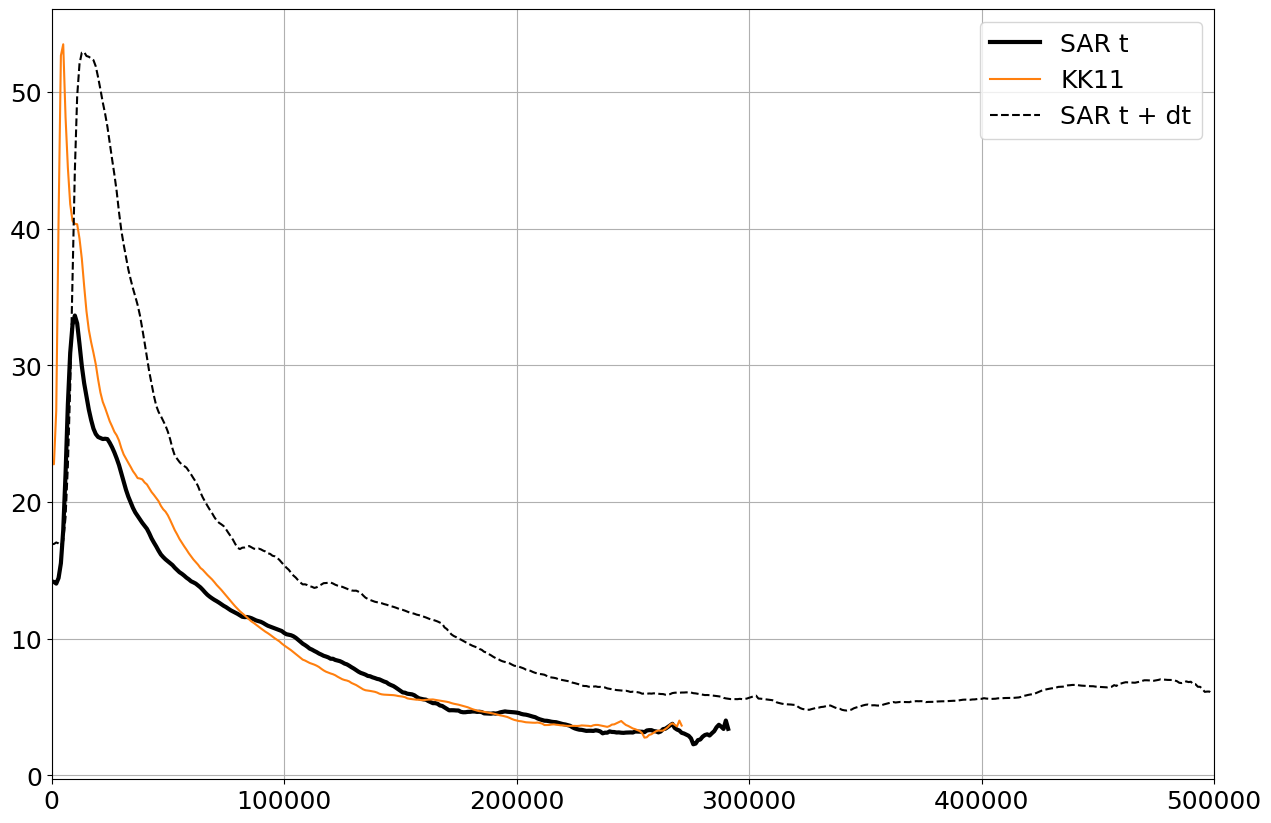

In [69]:
lbda  = 0.4
v_new = v_k10(V1, t=0.79, lbda=lbda)
plt.plot(ws1.rad, ws1, label='SAR t', c='k', linewidth=3)
plt.plot(V1.rad * L1, v_new * fcor1 * L1, label='KK11', c='tab:orange')
plt.plot(ws2.rad, ws2, label='SAR t + dt', c='k', linestyle='--')
plt.grid();plt.xlim(0, 500000)
plt.legend()

/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in sqrt
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: invalid value encountered in divide
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-packages/xarray/core/computation.py:771: RuntimeWarning: divide by zero encountered in log
  result_data = func(*input_data)
/home/arthur/anaconda3/envs/paramProfiles/lib/python3.8/site-pack

(0.0, 5.0)

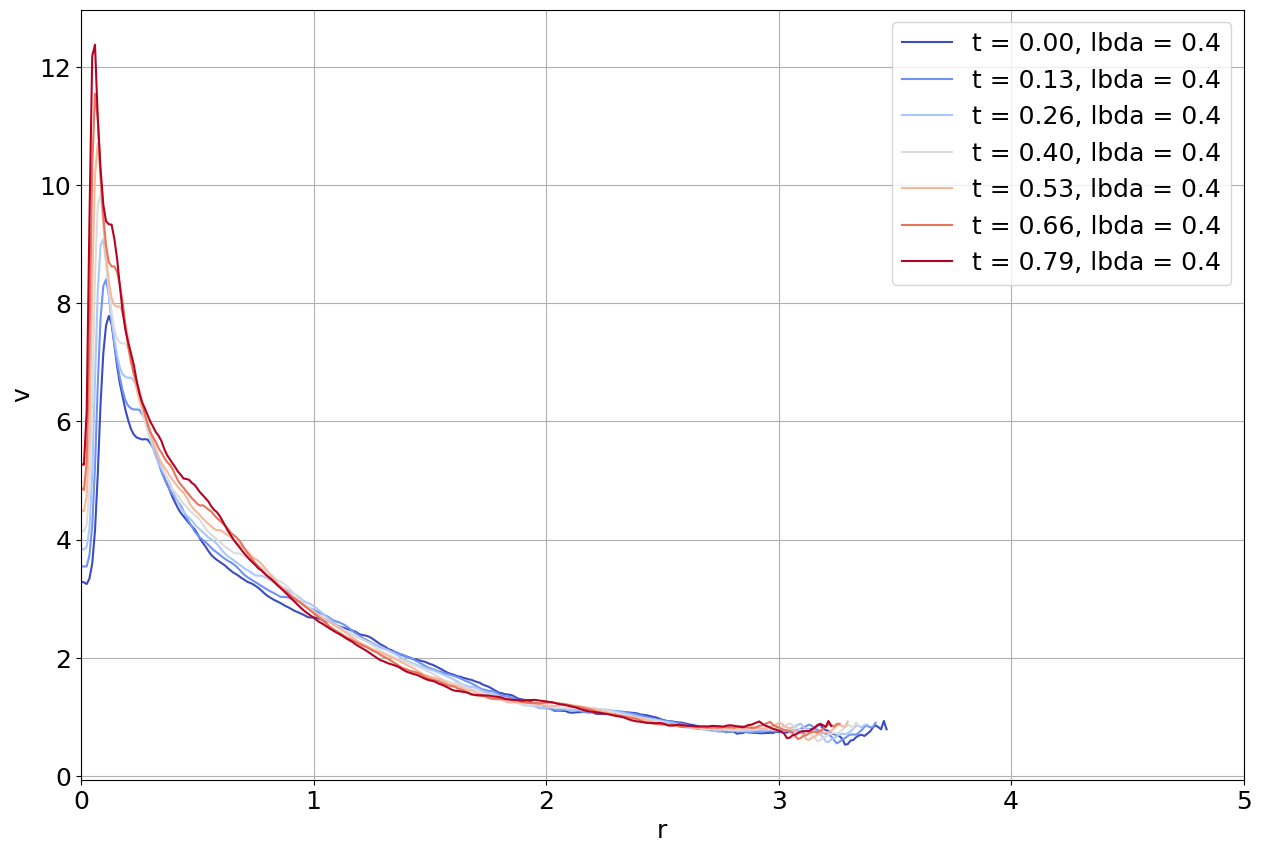

In [71]:
### TEMPORAL EVOLUTION
ts     = np.linspace(0, 0.79, 7)
colors = mpl.cm.coolwarm(np.linspace(0, 1, len(ts)))

for i, t in enumerate(ts):
    plt.plot(V1.rad, v_k10(V1, t=t, lbda=lbda), label='t = {:.2f}, lbda = {:.1f}'.format(t, lbda), c=colors[i])
plt.grid();plt.legend()
plt.xlabel('r');plt.ylabel('v')
plt.xlim(0, 5)